In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST
import numpy as np
from matplotlib import pylab as plt

In [2]:
trainset = MNIST('../data/', train=True, transform=transforms.ToTensor())
testset = MNIST('../data/', train=True, transform=transforms.ToTensor())

len(trainset), len(testset)

(60000, 60000)

In [3]:
trainset[0][0].shape

torch.Size([1, 28, 28])

In [4]:
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

In [5]:
def plot_batch(loader, cols):
    imgs = next(iter(loader))[0]
    print(imgs.shape)
    grid = torchvision.utils.make_grid(imgs, nrow=cols).numpy().transpose([1, 2, 0])
    plt.figure(figsize=(13, 13))
    plt.axis('off')
    plt.imshow(grid)

torch.Size([64, 1, 28, 28])


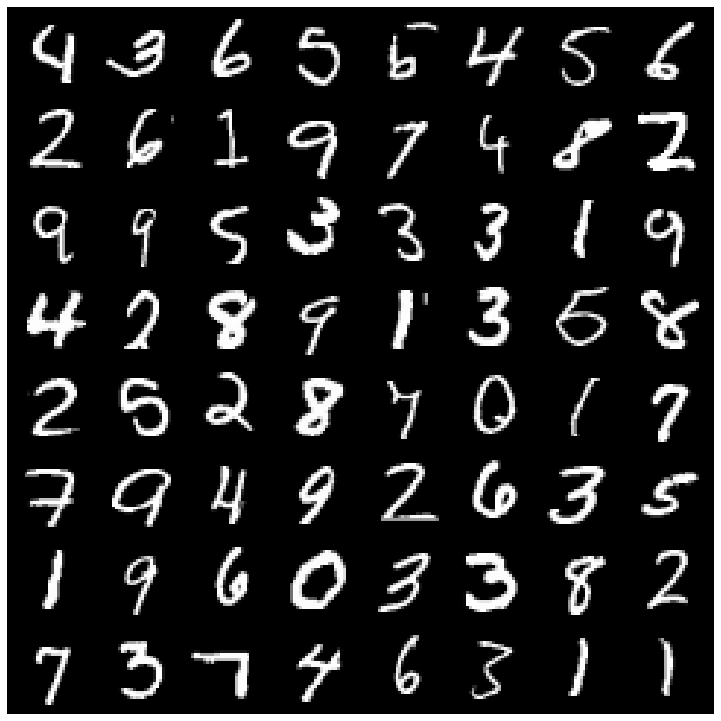

In [6]:
plot_batch(trainloader, 8)

In [7]:
class Identity_block(nn.Module):
    def __init__(self, in_filter, filters, activation=nn.ELU):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_filter, filters[0], 1)
        self.bn1 = nn.BatchNorm2d(filters[0])
        self.conv2 = nn.Conv2d(filters[0], filters[1], 3, padding=1)
        self.bn2 = nn.BatchNorm2d(filters[1])
        self.conv3 = nn.Conv2d(filters[1], filters[2], 1)
        self.bn3 = nn.BatchNorm2d(filters[2])
        self.activation = activation()
        
    def forward(self, x):
        shortcut = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.activation(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        
        x = x + shortcut
        
        x = self.activation(x)
        
        return x

In [8]:
class Conv_block(nn.Module):
    def __init__(self, in_filter, filters, activation=nn.ELU):
        super().__init__()
        
        self.max_pool = nn.MaxPool2d(2, 2)
        
        self.conv1 = nn.Conv2d(in_filter, filters[0], 1)
        self.bn1 = nn.BatchNorm2d(filters[0])
        self.conv2 = nn.Conv2d(filters[0], filters[1], 3, padding=1)
        self.bn2 = nn.BatchNorm2d(filters[1])
        self.conv3 = nn.Conv2d(filters[1], filters[2], 1)
        self.bn3 = nn.BatchNorm2d(filters[2])
        
        self.conv_shortcut = nn.Conv2d(in_filter, filters[2], 1)
        self.bn_shortcut = nn.BatchNorm2d(filters[2])
        
        self.activation = activation()
        
    def forward(self, x):
        x = self.max_pool(x)
        
        shortcut = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.activation(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        
        shortcut = self.conv_shortcut(shortcut)
        shortcut = self.bn_shortcut(shortcut)
        x = x + shortcut
        
        x = self.activation(x)
        
        return x

In [9]:
class Resnet(nn.Module):
    def __init__(self, num_outputs, activation=nn.ELU):
        super().__init__()
        
        self.conv_0 = nn.Conv2d(1, 8, 3, padding=1)
        self.bn_0 = nn.BatchNorm2d(8)
        self.activate_0 = activation() 
        
        self.conv_block_1 = Conv_block(8, [16, 16, 64], activation=activation)
        self.identity_block_2 = Identity_block(64, [16, 16, 64], activation=activation)
        self.identity_block_3 = Identity_block(64, [16, 16, 64], activation=activation)
        
        self.conv_block_4 = Conv_block(64, [32, 32, 128], activation=activation)
        self.identity_block_5 = Identity_block(128, [32, 32, 128], activation=activation)
        self.identity_block_6 = Identity_block(128, [32, 32, 128], activation=activation)
        
        self.max_pool = nn.MaxPool2d(2, 2)
        
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.conv_0(x)
        x = self.bn_0(x)
        x = self.activate_0(x)
        
        x = self.conv_block_1(x)
        x = self.identity_block_2(x)
        x = self.identity_block_3(x)
        
        x = self.conv_block_4(x)
        x = self.identity_block_5(x)
        x = self.identity_block_6(x)
        
        x = self.global_avg_pool(x)
        x = self.flatten(x)
        x = self.fc(x)
        
        return x

In [10]:
resnet = Resnet(10)

In [11]:
resnet(next(iter(trainloader))[0]).size()

torch.Size([64, 10])

In [12]:
def train(net, trainloader, epochs=3, lr=0.001, history_step=200):
    net.train()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if torch.cuda.device_count() > 1:
        net = nn.DataParallel(net)
    net = net.to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    
    history_loss = []
    
    for epoch in range(epochs):
        for step, data in enumerate(trainloader):
            imgs, labels = data
            imgs = imgs.to(device)
            lables = labels.to(device)
            outputs = net(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if step % history_step == history_step - 1:
                print(f"epoch: {epoch + 1} -- step: {step + 1} -- loss: {loss:.4f}")
                history_loss.append(loss)

In [13]:
train(resnet, trainloader, epochs=1, lr=3e-4, history_step=50)

epoch: 1 -- step: 50 -- loss: 1.1765
epoch: 1 -- step: 100 -- loss: 0.4297
epoch: 1 -- step: 150 -- loss: 0.2758
epoch: 1 -- step: 200 -- loss: 0.2512
epoch: 1 -- step: 250 -- loss: 0.2098
epoch: 1 -- step: 300 -- loss: 0.1058
epoch: 1 -- step: 350 -- loss: 0.1792
epoch: 1 -- step: 400 -- loss: 0.1038
epoch: 1 -- step: 450 -- loss: 0.1347
epoch: 1 -- step: 500 -- loss: 0.1743
epoch: 1 -- step: 550 -- loss: 0.1041
epoch: 1 -- step: 600 -- loss: 0.1259
epoch: 1 -- step: 650 -- loss: 0.0617
epoch: 1 -- step: 700 -- loss: 0.0424
epoch: 1 -- step: 750 -- loss: 0.1450
epoch: 1 -- step: 800 -- loss: 0.0570
epoch: 1 -- step: 850 -- loss: 0.0978
epoch: 1 -- step: 900 -- loss: 0.1165


In [14]:
def evaluate(net, dataloader):
    net.eval()
    corrects = 0
    total = 0
    
    with torch.no_grad():
        for imgs, labels in dataloader:
            outputs = net(imgs)
            predictions = outputs.argmax(dim=1)
            corrects += (predictions == labels).sum()
            total += outputs.size()[0]
    
    return corrects.numpy() / total

In [15]:
evaluate(resnet, trainloader)

0.9816833333333334

In [16]:
evaluate(resnet, testloader)

0.9816833333333334